### Library

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Module
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
import os
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Download Path

In [3]:
Download_DataPath = os.path.join(os.getcwd(),'Data')

### Load  - Transoform - Normalize MINST Dateset

In [4]:
transform = transforms.Compose([transforms.Resize((28, 28)) ,transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.MNIST(root = Download_DataPath, train = True, transform = transform, download = True)
validation_dataset = datasets.MNIST(root = Download_DataPath, train = False, transform = transform, download = True)

### Prepare - Shuffle Data Batches

In [5]:
training_loader = DataLoader(dataset = training_dataset, shuffle = True, batch_size = 100)
validation_loader = DataLoader(dataset = validation_dataset, shuffle = True, batch_size = 100)

#### Transofrom Tesnor Image
- Tensor Image Of Shape (1, 28, 28) to (28, 28, 1)
- Remove Normalization
- Set Value Range From 0 -> 1 Instead Of -1 -> 1

In [6]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # Get Clone From The Tensor And Transfer To Numpy Array
    image = image.transpose(1, 2, 0) # Fix ARray Shape From (1, 28, 28) to (28, 28, 1) To Be Feeded Well To The Network ( Model )
    #print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # Remove Normalization
    image = image.clip(0, 1) # Clip Every -1 to 0 and Every 1 to 1 In The Array
    return image

### Load Data In Batches

In [7]:
dataIter = iter(training_loader) # Move Through Data Batches 
images, labels = next(dataIter) #( Load Batche One By One Mean Load Every 100 Image )

In [8]:
valdataIter = iter(validation_loader) # Move Through Data Batches 
vimages, vlabels = next(valdataIter) #( Load Batche One By One Mean Load Every 100 Image )

### Plot First 20 Image

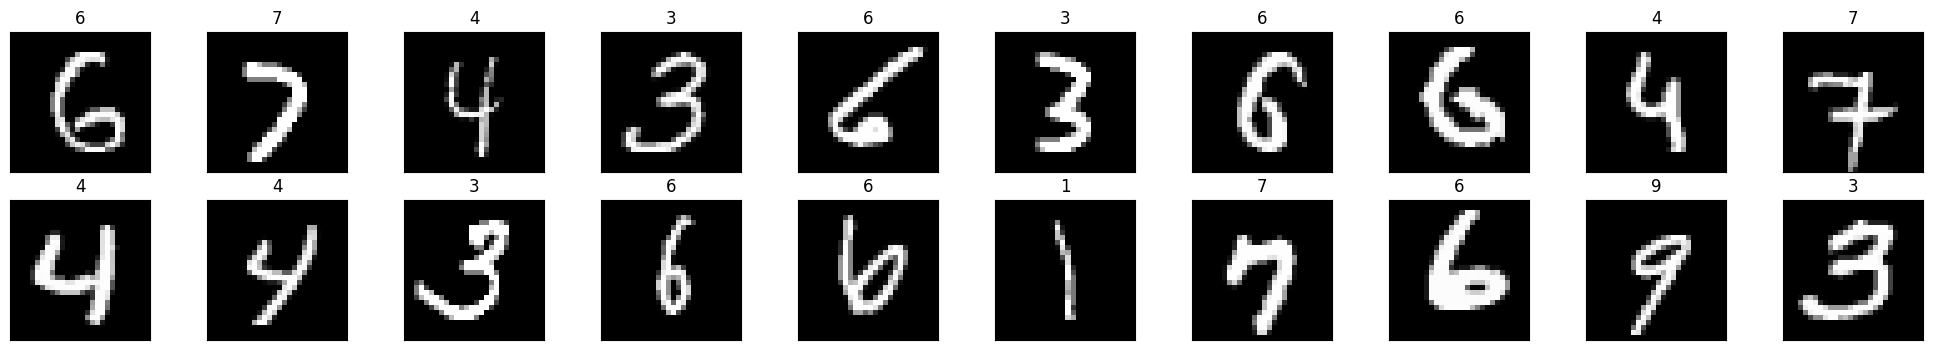

In [9]:
fig = plt.figure(figsize = (25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(labels[idx].item())

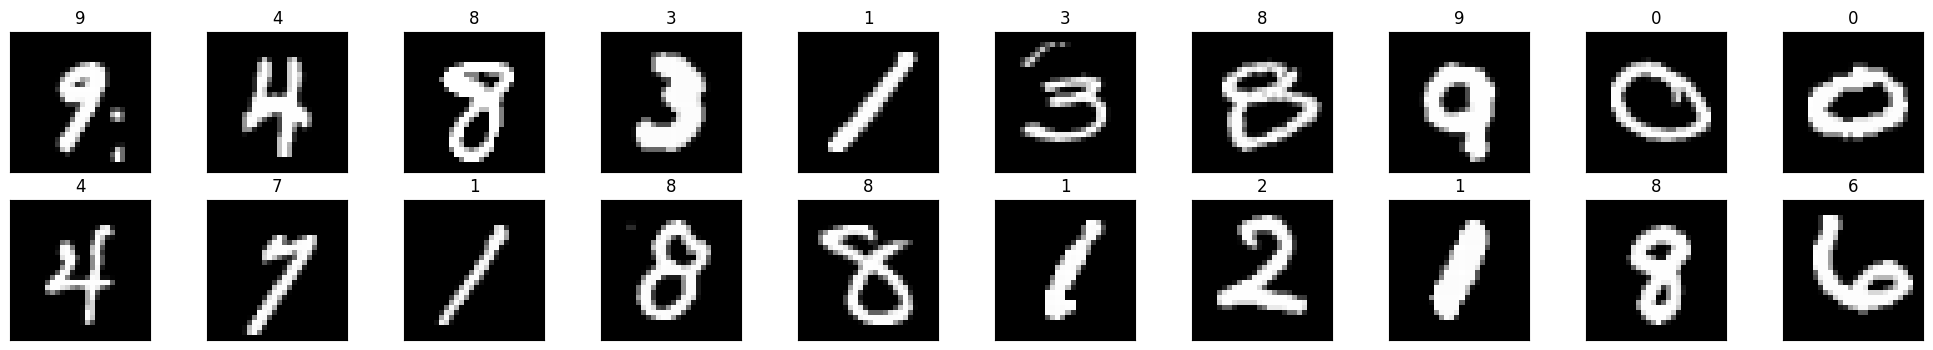

In [10]:
fig = plt.figure(figsize = (25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(im_convert(vimages[idx]))
    ax.set_title(vlabels[idx].item())

### Create Model

In [35]:
class LeNetCNNImageClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 5, stride = 1)
        self.dropout= nn.Dropout2d(0.3)
        self.conv2 = nn.Conv2d(in_channels = 20, out_channels = 50, kernel_size = 5, stride = 1)
        self.fc1 = nn.Linear(in_features = 4*4*50, out_features = 500)
        self.fc2 = nn.Linear(in_features = 500, out_features = 10)
    def forward(self, x):
        # Conv => Relu => Bool
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.max_pool2d(x, kernel_size = 2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size = 2, stride=2)

        x = x.view(-1, 4*4*50)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [36]:
model = LeNetCNNImageClassifier()

In [37]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.1354,  0.1668, -0.0064, -0.0631,  0.0261],
                        [ 0.1342,  0.0885, -0.1130, -0.0013, -0.1971],
                        [ 0.1720, -0.1670, -0.1407, -0.1591, -0.0218],
                        [ 0.1542,  0.0456, -0.0349, -0.0035, -0.0273],
                        [-0.0617, -0.0524,  0.0380,  0.0376, -0.0177]]],
              
              
                      [[[-0.0720, -0.0896,  0.1751, -0.0343, -0.0928],
                        [-0.0828, -0.0664, -0.1438, -0.1211,  0.0355],
                        [ 0.1855,  0.1474, -0.1744, -0.0775,  0.0546],
                        [-0.0585, -0.0334, -0.0711, -0.1333, -0.0463],
                        [-0.0155,  0.1493,  0.0716,  0.1383,  0.0371]]],
              
              
                      [[[-0.0274,  0.1539,  0.1349, -0.0166, -0.0584],
                        [-0.1283, -0.0456, -0.0755,  0.0540,  0.0782],
                        [ 0.1993,  0.1271, -0.0602,  0

### Loss Function , Optimizer

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

### Train The Model

In [39]:
epochs = 15
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0.0
    val_running_loss = 0.0
    val_running_correct = 0.0
    for inputs, labels in training_loader:
        # inputs = inputs.view(inputs.shape[0], -1) #(100, 784 = 28*28)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1) # max score from outputs scores [0 -> 1] Cross Entropy with softmax
        running_loss += loss.item() # the current loss at the batch iteration
        running_correct += torch.sum(pred == labels.data)
    else:
        with torch.no_grad():
          for val_inputs, val_labels in validation_loader:
            # val_inputs = val_inputs.view(val_inputs.shape[0], -1) #(100, 784 = 28*28)
            val_outputs = model(val_inputs)          
            val_loss = criterion(val_outputs, val_labels)

            _, val_pred = torch.max(val_outputs, 1) # max score from outputs scores [0 -> 1] Cross Entropy with softmax
            val_running_loss += val_loss.item() # the current loss at the batch iteration
            val_running_correct += torch.sum(val_pred == val_labels.data)

            val_epoch_loss = val_running_loss / len(validation_loader) # avg epoch loss
            val_epoch_acc = val_running_correct.float() / len(validation_loader) # avg epoch accuracy
            val_running_loss_history.append(val_epoch_loss)
            val_running_correct_history.append(val_epoch_acc)

        
        epoch_loss = running_loss / len(training_loader) # avg epoch loss
        epoch_acc = running_correct.float() / len(training_loader) # avg epoch accuracy
        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_acc)
        
        print(f'Epoch {epoch}')
        print('epoch loss {:.4f},   epoch accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation epoch loss {:.4f},   validation epoch accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))        


Epoch 0
epoch loss 0.5783,   epoch accuracy 84.9267
validation epoch loss 0.2029,   validation epoch accuracy 94.0200
Epoch 1
epoch loss 0.1658,   epoch accuracy 95.2050
validation epoch loss 0.1135,   validation epoch accuracy 96.7600
Epoch 2
epoch loss 0.1073,   epoch accuracy 96.8617
validation epoch loss 0.0826,   validation epoch accuracy 97.5200
Epoch 3
epoch loss 0.0812,   epoch accuracy 97.5883
validation epoch loss 0.0667,   validation epoch accuracy 98.0300
Epoch 4
epoch loss 0.0670,   epoch accuracy 97.9967
validation epoch loss 0.0561,   validation epoch accuracy 98.1600
Epoch 5
epoch loss 0.0581,   epoch accuracy 98.2750
validation epoch loss 0.0475,   validation epoch accuracy 98.5200
Epoch 6
epoch loss 0.0508,   epoch accuracy 98.4867
validation epoch loss 0.0442,   validation epoch accuracy 98.7200
Epoch 7
epoch loss 0.0456,   epoch accuracy 98.6367
validation epoch loss 0.0431,   validation epoch accuracy 98.6400
Epoch 8
epoch loss 0.0407,   epoch accuracy 98.7733
vali

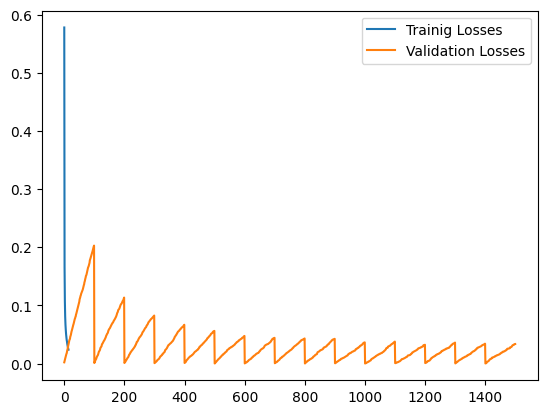

In [40]:
plt.plot(running_loss_history, label = 'Trainig Losses')
plt.plot(val_running_loss_history, label = 'Validation Losses')
plt.legend()
plt.show()

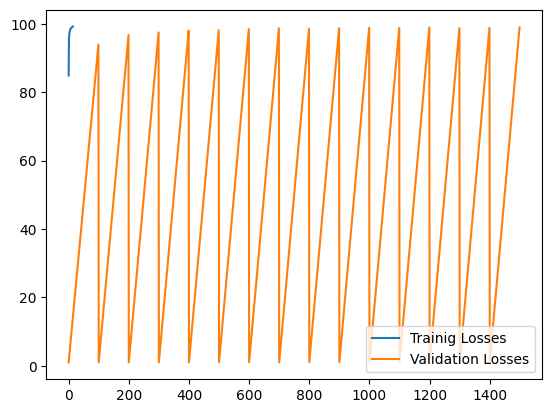

In [41]:
plt.plot(running_correct_history, label = 'Trainig Losses')
plt.plot(val_running_correct_history, label = 'Validation Losses')
plt.legend()
plt.show()

#### Test Model

In [45]:
import requests
import PIL.ImageOps
import PIL 
from PIL import Image

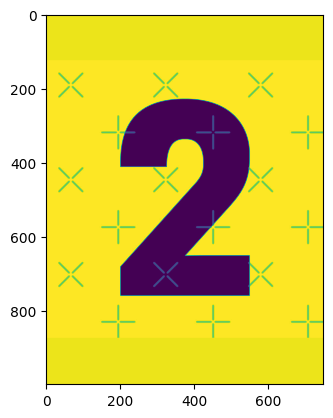

In [46]:
url = "https://ih1.redbubble.net/image.869970764.1635/flat,750x,075,f-pad,750x1000,f8f8f8.jpg"
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

## Image Processing
#### Image To be Feeded Must be Black white and black color 

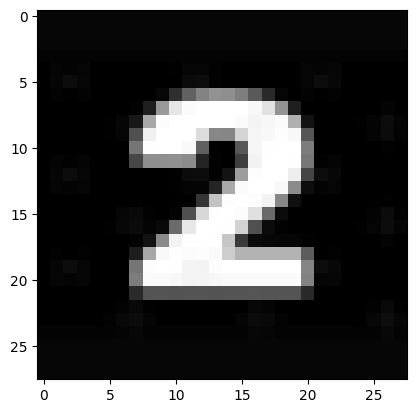

In [47]:
img = PIL.ImageOps.invert(img.convert('RGB'))
img =img.convert(mode ="L")
img = transform(img)
plt.imshow(im_convert(img))

#### Prediction

In [48]:
# img = img.view(img.shape[0], -1) #(100, 784 = 28*28)
outputs = model(img)
_, pred = torch.max(outputs, 1)
print(pred.item())

2


In [49]:
images = vimages.view(vimages.shape[0], -1)
images.shape

torch.Size([100, 784])

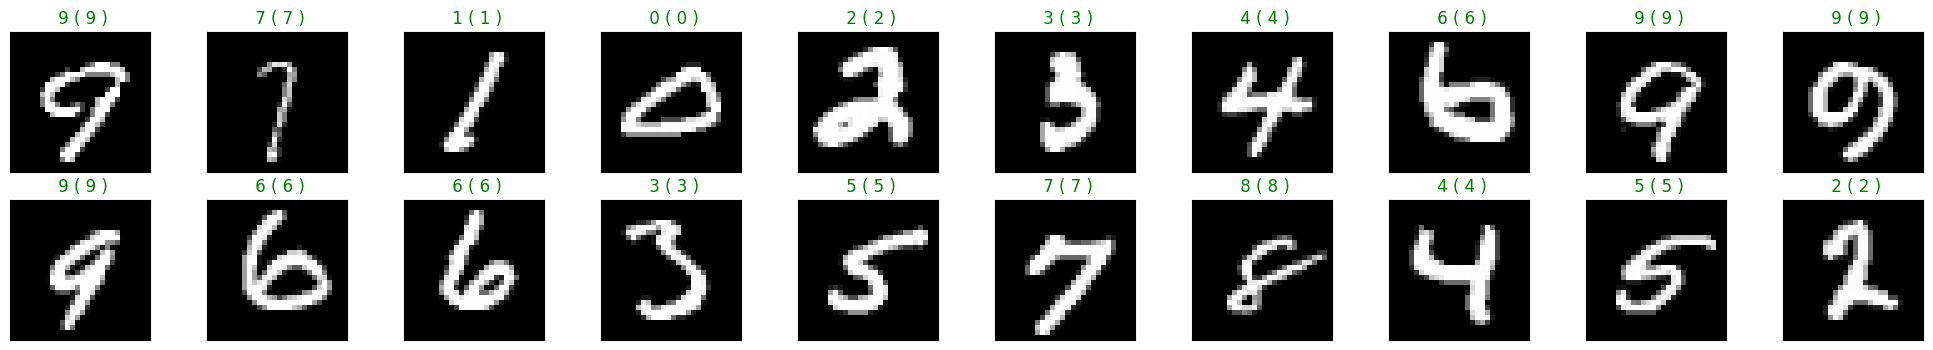

In [50]:
valdataIter = iter(validation_loader)
images, labels = next(valdataIter)
# images = images.view(images.shape[0], -1)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize = (25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(f' {str(preds[idx].item())} ( {str(labels[idx].item())} )', color = ('green' if preds[idx] == labels[idx] else 'red'))